# 4. Model Evaluation & Benchmarking

**Goal:** Evaluate the performance of the pipeline's models. 
1.  Benchmark the pipeline's fast **VADER** model against our high-accuracy **`bert_sentiment`** model.
2.  Generate a Classification Report and Confusion Matrix for the presentation.
3.  Display the final `opportunity_scores.csv` generated by the pipeline.

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

# Define paths
DATA_PATH = Path("../outputs/docs_with_sentiment.csv")
BERT_MODEL_PATH = Path("../models/bert_sentiment")
OPP_SCORES_PATH = Path("../outputs/opportunity_scores.csv")

/Users/davidket/Desktop/NLP_Market Opportunity Analyser/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load Pipeline Data
We load the data file that contains the VADER sentiment scores calculated by `src/sentiment_models.py`.

In [2]:
if not DATA_PATH.exists():
    print(f"ERROR: {DATA_PATH} not found. Please run the main pipeline first.")
else:
    df = pd.read_csv(DATA_PATH, low_memory=False)
    print(f"Loaded {len(df)} documents with VADER sentiment.")
    display(df[['text_clean', 'topic_id', 'vader_compound', 'sent_label']].head())

Loaded 31416 documents with VADER sentiment.


,text_clean,topic_id,vader_compound,sent_label
0,Good Quality Dog Food. I have bought several o...,10,0.9583,pos
1,Not as Advertised. Product arrived labeled as ...,-1,-0.5664,neg
2,"""Delight"" says it all. This is a confection th...",-1,0.9066,pos
3,Cough Medicine. If you are looking for the sec...,6,0.4404,pos
4,Great taffy. Great taffy at a great price. Th...,-1,0.9661,pos


### 2. Benchmark: VADER vs. BERT

We will treat our `bert_sentiment` model as the "ground truth" to see how well VADER performs.

We will only run this on a **sample** of the data (e.g., 500 rows) because the BERT model is very slow.

In [9]:
if 'df' in locals():
    # Load the high-accuracy BERT model from the local folder
    print("Loading local BERT model...")
    bert_pipeline = pipeline('sentiment-analysis', model=BERT_MODEL_PATH)
    print("BERT model loaded.")
    
    # --- FIX IS HERE ---
    # 1. Filter the *entire* DataFrame first to get only pos/neg reviews
    print("Filtering for non-neutral VADER reviews...")
    df_filtered = df[df['sent_label'] != 'neu'].copy()
    
    # 2. Now, sample from that *filtered* DataFrame
    if len(df_filtered) > 500:
        df_sample = df_filtered.sample(n=500, random_state=42).copy()
    else:
        df_sample = df_filtered.copy() # Take all if less than 500
    
    if len(df_sample) == 0:
        print("ERROR: Your dataset has no 'positive' or 'negative' VADER reviews to sample from.")
    else:
        print(f"Sampling {len(df_sample)} non-neutral reviews.")
    # --- END OF FIX ---

        # Run BERT pipeline on the sample texts
        print(f"Running BERT on {len(df_sample)} samples (this may take a minute)...")
        bert_results = bert_pipeline(df_sample['text_clean'].tolist(), truncation=True)
        print("BERT analysis complete.")
        
        # Add BERT results to our sample DataFrame
        df_sample['bert_label'] = [r['label'] for r in bert_results]
        df_sample['bert_score'] = [r['score'] for r in bert_results]
        
        display(df_sample[['text_clean', 'sent_label', 'bert_label']].head())

Device set to use cpu


Loading local BERT model...
BERT model loaded.
Filtering for non-neutral VADER reviews...
Sampling 500 non-neutral reviews.
Running BERT on 500 samples (this may take a minute)...
BERT analysis complete.


,text_clean,sent_label,bert_label
4003,Misleading Packaging!. I meant to pick up the ...,pos,LABEL_2
9989,If you have to use formula this is a good choi...,pos,LABEL_2
1883,if you love them... you love them... popchips....,pos,LABEL_2
8867,Excellent decaf. I normally drink Lavazza Ross...,pos,LABEL_2
9259,Wolfgang Puck Sumatra. This coffee says Dark R...,pos,LABEL_2


### 3. Deeper Evaluation: Classification Report

Now we compare VADER's `sent_label` (pos, neg, neu) to BERT's `bert_label` (POSITIVE, NEGATIVE).

We will map them to a simple binary `pos`/`neg` to compare fairly.

In [19]:
if 'df_sample' in locals() and not df_sample.empty:
    
    # --- FIX IS HERE ---
    # Create a map for BERT's generic labels
    # We learned this from the confusing matrix:
    label_map = {
        'LABEL_0': 'NEGATIVE',
        'LABEL_1': 'NEUTRAL', # (Assuming LABEL_1 is neutral)
        'LABEL_2': 'POSITIVE',
        'NEGATIVE': 'NEGATIVE', # (Just in case)
        'POSITIVE': 'POSITIVE'  # (Just in case)
    }
    
    # Map VADER 'pos'/'neg' to 'POSITIVE'/'NEGATIVE'
    vader_labels = df_sample['sent_label'].map({'pos': 'POSITIVE', 'neg': 'NEGATIVE'})
    
    # Map BERT labels to 'POSITIVE'/'NEGATIVE'
    bert_labels_true = df_sample['bert_label'].map(label_map)
    # --- END OF FIX ---

    # We can now use the simple labels list
    final_labels = ['POSITIVE', 'NEGATIVE']

    print("--- Classification Report (VADER vs. BERT) ---")
    print(f"Comparing labels: {final_labels}\n")
    
    # We pass the final labels list and set zero_division=0
    print(classification_report(bert_labels_true, vader_labels, labels=final_labels, zero_division=0))
else:
    print("df_sample is empty. Run the previous cell or check your data.")

--- Classification Report (VADER vs. BERT) ---
Comparing labels: ['POSITIVE', 'NEGATIVE']

              precision    recall  f1-score   support

    POSITIVE       0.97      0.95      0.96       467
    NEGATIVE       0.49      0.64      0.55        33

    accuracy                           0.93       500
   macro avg       0.73      0.79      0.76       500
weighted avg       0.94      0.93      0.94       500



--- Confusion Matrix (Cleaned Labels) ---


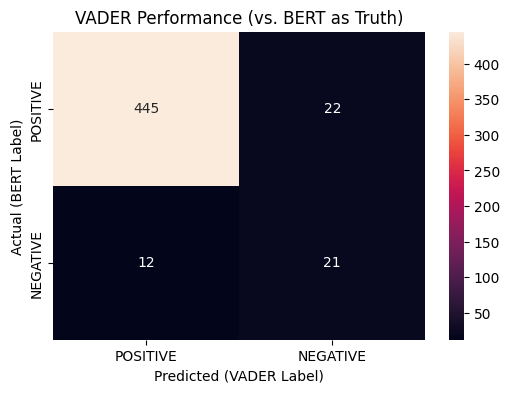

*** Screenshot this NEW 2x2 matrix for your presentation! ***


In [20]:
if 'df_sample' in locals() and 'vader_labels' in locals():
    print(f"--- Confusion Matrix (Cleaned Labels) ---")
    
    # Re-use the variables from the cell above
    cm = confusion_matrix(bert_labels_true, vader_labels, labels=final_labels)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=final_labels, 
                yticklabels=final_labels)
    plt.title('VADER Performance (vs. BERT as Truth)')
    plt.ylabel('Actual (BERT Label)')
    plt.xlabel('Predicted (VADER Label)')
    plt.show()
    
    print("*** Screenshot this NEW 2x2 matrix for your presentation! ***")
else:
    print("Run the previous cell to create the cleaned labels first.")

### 4. Final Pipeline Output: Opportunity Scores

This is the final, most important file generated by the pipeline, which is loaded by the Streamlit app.

In [21]:
if OPP_SCORES_PATH.exists():
    print(f"Loading final opportunity scores from {OPP_SCORES_PATH}")
    final_scores = pd.read_csv(OPP_SCORES_PATH)
    display(final_scores.sort_values('opportunity_score', ascending=False).head(10))
else:
    print(f"ERROR: {OPP_SCORES_PATH} not found. Run the full pipeline.")

Loading final opportunity scores from ../outputs/opportunity_scores.csv


,topic_id,mentions,mean_sentiment,neg_fraction,raw_opportunity,opportunity_score,top_terms,examples
0,-1,3376,0.641868,0.125296,423.0,100.000000,"['br', 'coffee', 'great', 'good', 'like', 'pro...","[""WOW! That's some good espresso. I use this ..."
1,6,520,0.720955,0.094231,49.0,11.583924,"['tea', 'br', 'great', 'like', 'good', 'green'...","[""powder instead of leaf. First, let me state ..."
2,10,305,0.696501,0.108197,33.0,7.801418,"['food', 'dog', 'br', 'dog food', 'dogs', 'gre...",['Premium dog food. My 3 dogs love this food a...
3,41,181,0.482465,0.182320,33.0,7.801418,"['product', 'great', 'price', 'br', 'good', 'a...",['heavy duty!. This is a hefty roll of mylar! ...
4,23,209,0.599860,0.153110,32.0,7.565012,"['coffee', 'cups', 'br', 'cup', 'use', 'great'...",['Review of DisposaKups. Got product on time -...
5,36,401,0.725246,0.069825,28.0,6.619385,"['br', 'orange', 'juice', 'drink', 'soda', 'br...","['Flavorful, and good!. This small can of juic..."
6,7,212,0.646266,0.132075,28.0,6.619385,"['cat', 'food', 'br', 'cats', 'love', 'treats'...","[""Quanty????. This food is working well for my..."
7,26,340,0.746358,0.079412,27.0,6.382979,"['coffee', 'great', 'good', 'like', 'taste', '...","['Taste good to me. I\'m not a coffee snob, so..."
8,48,338,0.735296,0.079882,27.0,6.382979,"['chips', 'br', 'good', 'great', 'kettle', 'po...",['dripping in oil. I purchased these because o...
9,45,370,0.764523,0.064865,24.0,5.673759,"['chocolate', 'hot', 'cocoa', 'br', 'hot choco...",['Great cocoa !!. Super good price and the bes...
